In [2]:
from google.colab import files
uploaded = files.upload()


Saving realtor-data.zip.xlsx to realtor-data.zip.xlsx


In [7]:
df.columns

Index(['brokered_by', 'status', 'price', 'bed', 'bath', 'acre_lot', 'street',
       'city', 'state', 'zip_code', 'house_size', 'prev_sold_date'],
      dtype='object')

In [5]:
import pandas as pd

# Load the Excel file
df = pd.read_excel("realtor-data.zip.xlsx")

# Strip whitespace from state names (just in case)
df['state'] = df['state'].str.strip()

# Filter to top 10 states
target_states = [
    'Texas', 'California', 'Florida', 'New York', 'Georgia',
    'North Carolina', 'Pennsylvania', 'Illinois', 'Arizona', 'Ohio'
]
filtered_df = df[df['state'].isin(target_states)]

# Drop rows with missing values
filtered_df = filtered_df.dropna(subset=['price', 'house_size', 'city'])

# Adjust sample size dynamically
sample_size = min(10000, len(filtered_df))
sampled_df = filtered_df.sample(n=sample_size, random_state=42)

# Save to CSV
sampled_df.to_csv("real_estate_filtered_10states.csv", index=False)

# Preview
sampled_df.head()


,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
378733,9040.0,for_sale,590000.0,4.0,4.0,2.23,258667.0,Canton,Georgia,30114.0,2546.0,2022-04-29
164425,45821.0,for_sale,245000.0,5.0,3.0,0.06,1385025.0,Pittsburgh,Pennsylvania,15206.0,2032.0,2018-02-15
521738,28613.0,for_sale,524990.0,3.0,3.0,0.10,460962.0,Saint Petersburg,Florida,33713.0,1780.0,NaT
506444,78482.0,for_sale,67000.0,1.0,2.0,NaN,859416.0,West Palm Beach,Florida,33415.0,661.0,2003-05-05
1034910,18665.0,for_sale,299500.0,3.0,3.0,NaN,1194335.0,Chandler,Texas,75758.0,1990.0,NaT


In [23]:
# Round numeric fields safely
sampled_df.loc[:, 'price'] = sampled_df['price'].round(0)
sampled_df.loc[:, 'house_size'] = sampled_df['house_size'].round(0)

# Convert date to string safely
sampled_df.loc[:, 'prev_sold_date'] = sampled_df['prev_sold_date'].astype(str)


### 1. Average Listing Price by State

This analysis identifies which U.S. states in the dataset have the highest average listing prices. It's a crucial insight for investors or agencies targeting premium real estate markets.

- **Business Insight:** States like California or New York may exhibit significantly higher average prices due to demand, urban density, or luxury markets.


In [9]:
avg_price_by_state = sampled_df.groupby('state')['price'].mean().sort_values(ascending=False)
avg_price_formatted = avg_price_by_state.apply(lambda x: "${:,.0f}".format(x))
avg_price_formatted


,price
state,
New York,"$1,290,477"
Florida,"$790,268"
Texas,"$536,554"
North Carolina,"$489,691"
Georgia,"$458,489"
Pennsylvania,"$423,103"
Illinois,"$416,618"
Ohio,"$290,921"


### 2. Average Price per Square Foot by State

By dividing listing price by house size, we calculate the average cost per square foot. This metric normalizes for property size and helps identify areas where real estate is most expensive on a unit basis.

- **Business Insight:** A high price per sqft could indicate strong location value even for smaller properties (e.g., urban cores).


In [10]:
# Calculate price per sqft if not already done
sampled_df['price_per_sqft'] = sampled_df['price'] / sampled_df['house_size']

# Group by state
ppsf = sampled_df.groupby('state')['price_per_sqft'].mean().sort_values(ascending=False)

# Format as currency
ppsf_formatted = ppsf.apply(lambda x: "${:,.2f}".format(x))
ppsf_formatted


,price_per_sqft
state,
New York,$592.51
Florida,$343.00
Texas,$217.35
North Carolina,$215.87
Pennsylvania,$191.18
Illinois,$188.72
Georgia,$181.24
Ohio,$141.27


### 3. States with Small Homes but High Prices

Here, I compare the average house size and average price by state to spot markets where consumers pay more for less space.

- **Business Insight:** These may be ideal for condo developments, rentals, or high-demand urban redevelopment.


In [11]:
# Calculate mean house_size and price by state
state_summary = sampled_df.groupby('state')[['house_size', 'price']].mean().sort_values(by='price', ascending=False)

# Format for presentation
state_summary_formatted = state_summary.copy()
state_summary_formatted['price'] = state_summary_formatted['price'].apply(lambda x: "${:,.0f}".format(x))
state_summary_formatted['house_size'] = state_summary_formatted['house_size'].apply(lambda x: "{:,.0f} sqft".format(x))

# Display
state_summary_formatted


,house_size,price
state,,
New York,"2,114 sqft","$1,290,477"
Florida,"1,973 sqft","$790,268"
Texas,"2,313 sqft","$536,554"
North Carolina,"2,172 sqft","$489,691"
Georgia,"2,433 sqft","$458,489"
Pennsylvania,"2,134 sqft","$423,103"
Illinois,"2,050 sqft","$416,618"
Ohio,"1,980 sqft","$290,921"


### 4. Top 10 Cities by Average Listing Price

This reveals the cities with the highest average listing prices across the 10-state dataset. These hotspots may indicate luxury zones or coastal economic hubs.

- **Business Insight:** Useful for high-end broker targeting and marketing focus areas.


In [12]:
# Format top 10 cities by average price as USD
top_prices = sampled_df.groupby('city')['price'].mean().sort_values(ascending=False).head(10)

# Display with formatting
top_prices_formatted = top_prices.apply(lambda x: "${:,.0f}".format(x))
top_prices_formatted


,price
city,
Hewlett Bay Park,"$18,200,000"
Palm Beach,"$11,849,090"
Captiva,"$11,700,000"
Old Westbury,"$9,995,000"
Coral Gables,"$9,905,000"
Sag Harbor,"$7,613,000"
Ben Wheeler,"$7,495,000"
Salado,"$7,000,000"
Anna Maria,"$6,900,000"


### 5. Top Brokers/Agencies by Listing Volume

I rank brokers or agencies by number of listings to identify the most active players in the market.

- **Business Insight:** High-volume brokers may control regional inventory and could be strategic partners.


In [13]:
sampled_df['brokered_by'].value_counts().head(10)


,count
brokered_by,
22611.0,254
16829.0,134
23592.0,65
57595.0,60
30807.0,60
54293.0,51
53016.0,47
70650.0,41
84534.0,30


### 6. Price Trends by Bed/Bath Configuration

This analysis tracks how pricing shifts based on home layouts — bedroom and bathroom counts — to understand how structure influences value.

- **Business Insight:** Helps guide pricing strategies and renovation plans based on common configurations.


In [14]:
# Group by bed and bath, calculate average price
bed_bath_price = sampled_df.groupby(['bed', 'bath'])['price'].mean().sort_values(ascending=False)

# Format as dollar values
bed_bath_price_formatted = bed_bath_price.apply(lambda x: "${:,.0f}".format(x))

# Display top 15
bed_bath_price_formatted.head(15)


,,price
bed,bath,
10.0,11.0,"$36,000,000"
6.0,9.0,"$22,375,000"
8.0,9.0,"$22,300,000"
16.0,20.0,"$20,500,000"
8.0,7.0,"$19,995,000"
7.0,8.0,"$10,732,875"
9.0,17.0,"$9,875,000"
8.0,13.0,"$9,825,000"
6.0,11.0,"$9,500,000"


# US Real Estate Market Analysis (Top 10 States)
This analysis explores residential real estate trends across 10 key U.S. states using data from Realtor listings. I aim to identify:
- High-value property markets
- Price-per-square-foot comparisons
- Broker and listing patterns


In [15]:
import sqlite3

# Create in-memory SQLite database
conn = sqlite3.connect(":memory:")

# Load DataFrame into SQL table
sampled_df.to_sql("real_estate", conn, index=False, if_exists="replace")


10000

### SQL-Style Query Setup
loaded the cleaned dataset into an in-memory SQLite database to run SQL queries directly within this Colab notebook.


### SQL Query 1: Top 10 States by Average Listing Price
I use SQL to find which states have the highest average home prices in the dataset. This identifies premium regional markets.


In [16]:
query = """
SELECT state, ROUND(AVG(price), 0) AS avg_price
FROM real_estate
GROUP BY state
ORDER BY avg_price DESC
LIMIT 10
"""
pd.read_sql(query, conn)


,state,avg_price
0,New York,1290477.0
1,Florida,790268.0
2,Texas,536554.0
3,North Carolina,489691.0
4,Georgia,458489.0
5,Pennsylvania,423103.0
6,Illinois,416618.0
7,Ohio,290921.0


### Chart: Avg Listing Price by State
This bar chart visualizes which states have the highest average prices for residential listings.


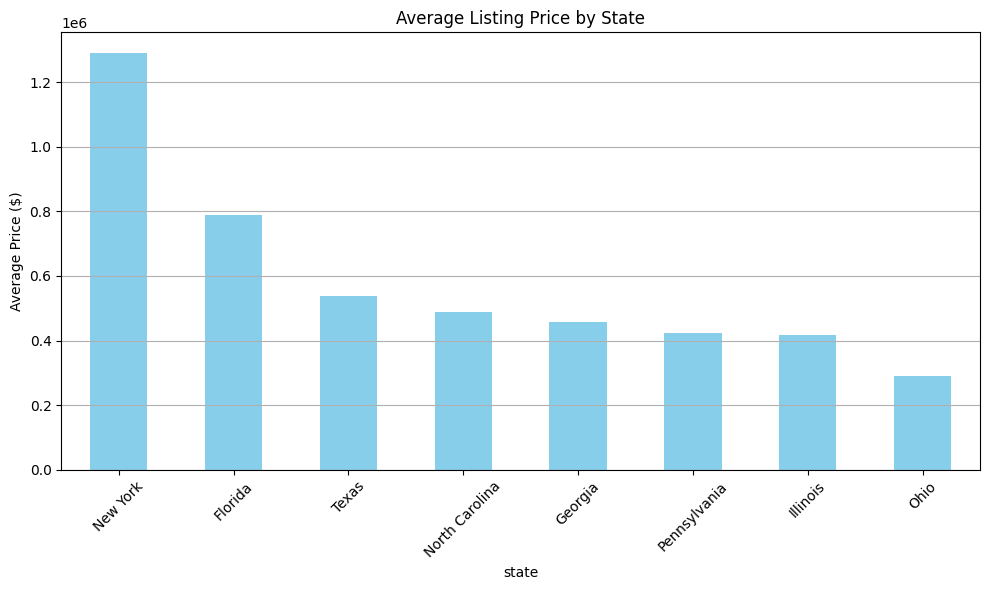

In [17]:
import matplotlib.pyplot as plt

avg_price = sampled_df.groupby('state')['price'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
avg_price.plot(kind='bar', color='skyblue')
plt.title("Average Listing Price by State")
plt.ylabel("Average Price ($)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Chart: Avg Price per Sqft by State
This horizontal bar chart shows which states have the most expensive land on a per-square-foot basis.


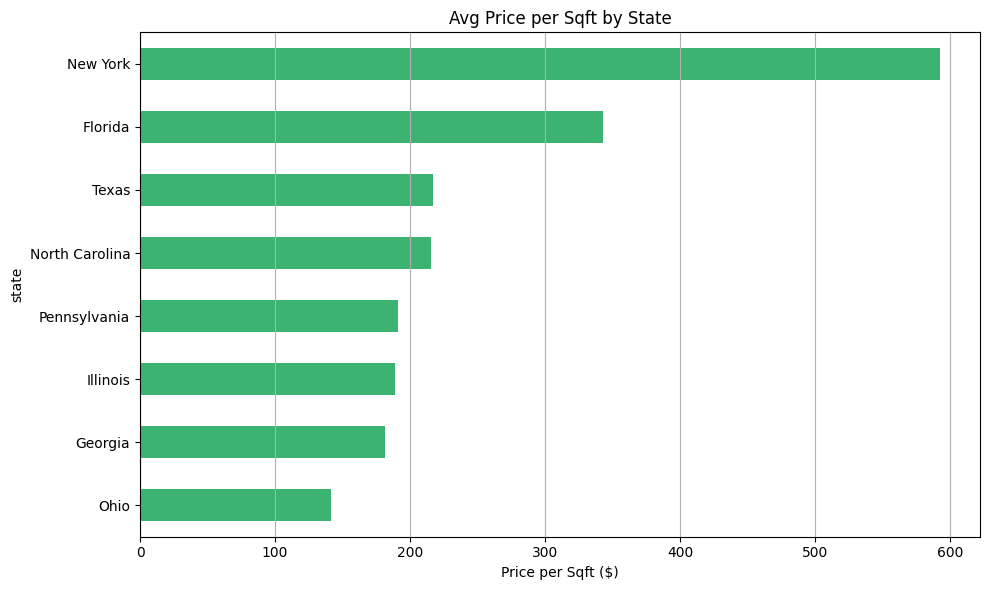

In [18]:
avg_ppsf = sampled_df.groupby('state')['price_per_sqft'].mean().sort_values()

plt.figure(figsize=(10,6))
avg_ppsf.plot(kind='barh', color='mediumseagreen')
plt.title("Avg Price per Sqft by State")
plt.xlabel("Price per Sqft ($)")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


### Bedroom & Bathroom Configuration Analysis

Understanding how property structure impacts price is essential for investors, developers, and agents.

In this section, we explore how different combinations of bedrooms and bathrooms influence listing prices using two views:

---

#### 1: Scatter Plot – Bedrooms vs Price (Colored by Bathrooms)
This plot shows how listing prices change with bedroom count. Each dot represents a property, colored by the number of bathrooms. It reveals:
- Outliers (e.g., luxury homes with 10+ beds)
- General pricing trends by bedroom
- How bathroom count affects value within bedroom groups

---

#### 2: Grouped Bar – Top 10 Bed/Bath Layouts by Avg Price
This view highlights the 10 most expensive bedroom/bathroom combinations based on average price. It is ideal for:
- Identifying premium home layouts
- Guiding design decisions in high-value markets
- Spotting luxury inventory for targeted campaigns

Together, these visuals help pinpoint structural patterns that drive home valuation across the 10-state sample.


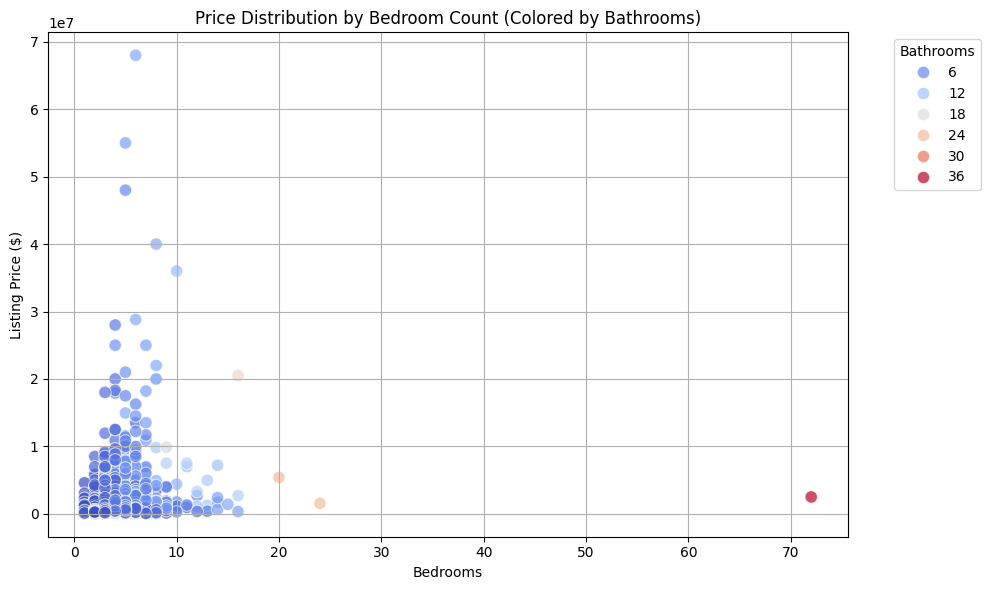

In [21]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(data=sampled_df, x='bed', y='price', hue='bath', palette='coolwarm', alpha=0.7, s=80)
plt.title("Price Distribution by Bedroom Count (Colored by Bathrooms)")
plt.xlabel("Bedrooms")
plt.ylabel("Listing Price ($)")
plt.legend(title='Bathrooms', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



<ipython-input-22-084e9639db6a>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_combos, x='layout', y='price', palette='viridis')


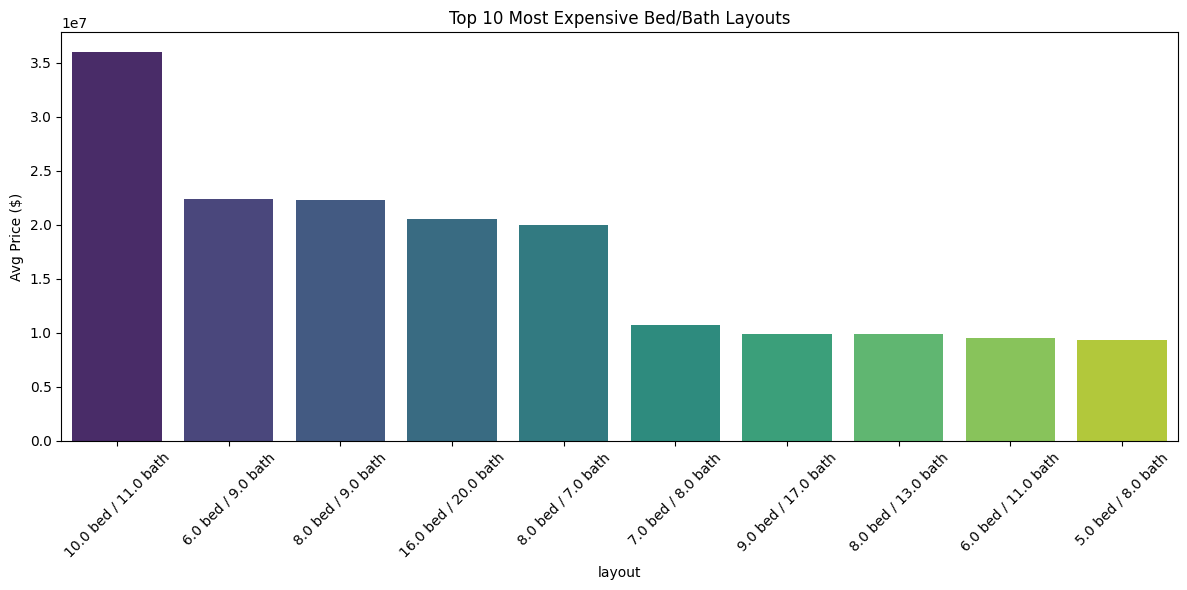

In [22]:
# Group and clean
bed_bath_avg = sampled_df.groupby(['bed', 'bath'])['price'].mean().reset_index()
top_combos = bed_bath_avg.sort_values(by='price', ascending=False).head(10)

# Format label
top_combos['layout'] = top_combos['bed'].astype(str) + " bed / " + top_combos['bath'].astype(str) + " bath"

# Plot
plt.figure(figsize=(12,6))
sns.barplot(data=top_combos, x='layout', y='price', palette='viridis')
plt.title("Top 10 Most Expensive Bed/Bath Layouts")
plt.xticks(rotation=45)
plt.ylabel("Avg Price ($)")
plt.tight_layout()
plt.show()


In [ ]:
sampled_df.to_csv("cleaned_real_estate_10states.csv", index=False)


In [ ]:
from google.colab import files
files.download("cleaned_real_estate_10states.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sampled_df.isna().sum()


,0
brokered_by,12
status,0
price,0
bed,131
bath,374
acre_lot,2535
street,70
city,0
state,0
zip_code,0


In [ ]:
# Fill numerics with median
sampled_df['brokered_by'] = sampled_df['brokered_by'].fillna(0)
sampled_df['bed'] = sampled_df['bed'].fillna(sampled_df['bed'].median())
sampled_df['bath'] = sampled_df['bath'].fillna(sampled_df['bath'].median())
sampled_df['acre_lot'] = sampled_df['acre_lot'].fillna(0)

# Fill text fields with placeholders
sampled_df['street'] = sampled_df['street'].fillna("Unknown")
sampled_df['prev_sold_date'] = sampled_df['prev_sold_date'].fillna("N/A")


In [ ]:
sampled_df.to_csv("final_real_estate_cleaned.csv", index=False)
from google.colab import files
files.download("final_real_estate_cleaned.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>